In [19]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid", font_scale=1.5, rc={'figure.figsize':(12, 6)})

# for custom notebook formatting.
from IPython.core.display import HTML
display(HTML('<style>.prompt{width: 0px; min-width: 0px; visibility: collapse}</style>'))
HTML(open('../custom.css').read())


<br><br><br>

## Natural Language Processing
### :::: Neural Networks ::::

<br><br><br><br><br><br>

In [78]:
D = pd.DataFrame(
        [[0,0,-1],
        [1,0,-1],
        [1,0,-1],
        [1,1,1],
        [1,1,1],
        [1,1,1],
        [0,0,-1],
        [0,0,-1],
        [0,1,-1]], columns=['free', 'money', 'label'])

# this was data from previous lecture:
# D = pd.DataFrame(
#        [[0,0,-1],
#         [1,0,1],
#         [1,1,-1],
#         [1,1,-1],
#         [1,0,-1],
#         [1,1,1],
#         [0,0,1],
#         [0,1,-1]], columns=['free', 'money', 'label'])

D

,free,money,label
0,0,0,-1
1,1,0,-1
2,1,0,-1
3,1,1,1
4,1,1,1
5,1,1,1
6,0,0,-1
7,0,0,-1
8,0,1,-1


In [75]:
## Logistic Regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
# lr = LogisticRegression(fit_intercept=False,  penalty=None, max_iter=3)
X = D[['free', 'money']].values
y = D.label.values
display(X)
display(y)
lr.fit(X, y)
print('coef=', lr.coef_)
# print('intercept=', lr.intercept_)

array([[0, 0],
       [1, 0],
       [1, 0],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 0],
       [0, 0],
       [0, 1]])

array([-1, -1, -1,  1,  1,  1, -1, -1, -1])

coef= [[0.8057828  1.04466014]]


In [76]:
lr.n_iter_

array([7], dtype=int32)

<br><br><br><br>

Logistic regression produces a **linear decision boundary** between the classes.

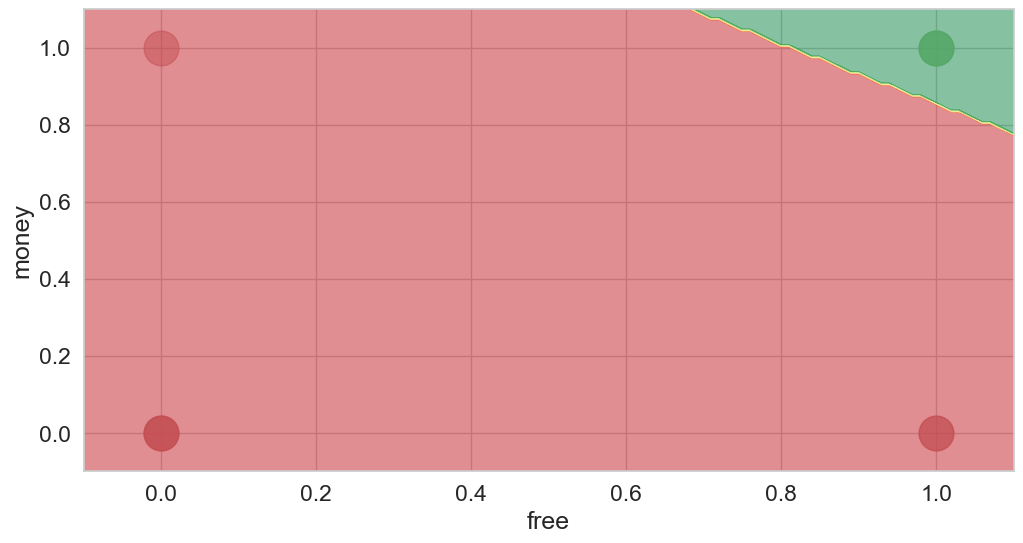

In [77]:
def plot_data(X, y, x0, x1):
    for xi, yi in zip(X, y):
        plt.plot(xi[0], xi[1], marker='.', ms=50, color='g' if yi == 1 else 'r', alpha=.5)
    plt.xlabel(x0)
    plt.ylabel(x1)
    
def plot_decision_surface(clf):
    xx0, xx1 = np.meshgrid(np.arange(-0.1, 1.1, .01), np.arange(-0.1, 1.1, .01))
    Z = clf.predict(np.c_[xx0.ravel(), xx1.ravel()])
    Z = Z.reshape(xx0.shape)
    cs = plt.contourf(xx0, xx1, Z, cmap=plt.cm.RdYlGn, alpha=.5)


plt.figure()
plot_data(X, y, 'free', 'money')
plot_decision_surface(lr)
plt.show()

**Why would we ever need a more complicated decision boundary?**

In [79]:
# "free free" -> spam
lr.predict([[0, 2]])

array([1])

Consider more complicated rules you might write for spam detection.

If document contains "free money" or "free credit report" but not "free tonight" ....


<br>

or consider sentiment classification (e.g., is this a positive or negative restaurant review):

If document contains "bad" -> negative  
If document contains "not bad" -> positive

or:

If document contains a bad comment about service -> negative  
If document contains bad comment about weather and good comment about food -> positive



### We need the flexibility to represent complex word interactions, without having to predefine them ourselves.


Consider having many classifiers for each possible topic:

- weather sentiment
- food sentiment
- service sentiment
- ...

We could then combine into a final overall sentiment prediction.

In [80]:
D = pd.DataFrame(
        [[1,0,0,1],
        [-1,0,0,-1],
        [1,0,-1,1],
        [1,0,-1,1],
        [-1,0,1,-1], 
        [-1,0,-1,-1],
        [1,1,1,1],
        [1,1,-1,1]], columns=['food', 'service', 'weather', 'label'])
D

,food,service,weather,label
0,1,0,0,1
1,-1,0,0,-1
2,1,0,-1,1
3,1,0,-1,1
4,-1,0,1,-1
5,-1,0,-1,-1
6,1,1,1,1
7,1,1,-1,1


In [81]:
X = D[['food', 'service', 'weather']].values
y = D.label.values
lr.fit(X, y)
print('coef=', lr.coef_)
print('intercept=', lr.intercept_)

coef= [[ 1.41124335  0.26270442 -0.17671098]]
intercept= [0.22660726]


...but, how do we discover that 'food', 'service', and 'weather' are important?

$\rightarrow$ **discover from the data.**

That's the idea behind neural networks: learn a **data representation** that is most predictive of class label.


## Neural Networks

A metaphor for describing computation.

<u> Logistic Regression as a Neural Network </u>

![nn](figs/nn.png)

## Multi-layer Neural Network

![nn2](figs/nn2.png)

Introduce $m$ <u> hidden nodes</u> $\vec{h} = \{h_1 \ldots h_m\}$.
- Like $m$ different classifiers (e.g., for "service", "food", "weather", ...)
  - Each with own set of parameters $\Theta = \{\Theta^1 \ldots \Theta^m\}$
  - e.g. $\vec{\Theta}^1 = \{\theta_1^1 \ldots \theta_d^1\}$
    - $\theta_i^j$: weight connecting input $i$ to hidden node $j$
- But, no associated labeled data for those classifiers.

Also introduce a classifier to map from hidden values $\vec{h}$ to label $y$
- with parameters $\vec{\lambda} = \{\lambda_1 \ldots \lambda_m\}$

<u>Conceptually</u>
- Identify $m$ different transformations of the input
- Combine those $m$ transformations into a prediction
- Allows <u> nonlinear</u> prediction functions


<br>

Whereas logistic regression function is:

$$f(\vec{x}, \vec{\theta}) = \frac{1}{1 + e^{-\vec{x} \cdot \vec{\theta}}}$$

the  neural net above defines the function:

$$f(\vec{x}, \Theta, \vec{\lambda}) = \frac{1}{1 + e^{-\vec{h} \cdot \vec{\lambda}}}$$

where

$$
h_i =  \frac{1}{1 + e^{-\vec{x} \cdot \vec{\Theta^i}}}
$$



## XOR problem

| $x_{1}$  | $x_{2}$ | $y$ |
|----------|----------|-------|
| 0        |     0    |  0    |
| 0        |     1    |  1    |
| 1        |     0    |  1    |
| 1        |     1    |  0    |


![xor](figs/xor.png)

![xor2](figs/xor2.png)

| $x_{1}$  | $x_{2}$  | $h_{1}$ | $h_{2}$ | $y_i$ |
|----------|----------|---------|---------|-------|
| 0        |     0    |  0      | 0       | 0     |
| 0        |     1    |  1      | -1      | 1     |
| 1        |     0    |  -1     | 1       | 1     |
| 1        |     1    |  0      | 0       | 0     |


![xor3](figs/xor3.png)




## Learning in neural nets

Consider the three layer neural network.  
How can we learn the parameters $\Theta$ and $\vec{\lambda}$?

![nn2](figs/nn2.png)

Recall our recipe...

### Gradient descent recipe

1.  Select a model type (e.g., linear, polynomial, etc)

2.  Select an **error function** that, when minimized, results in a good setting of the model parameters.

3.  Analytically determine the gradient of the error function with respect to the model parameters.

4.  Iteratively change the parameters by a small amount in the direction of the gradient until the (near) minimum of the error function is found.


<br><br>

Our function is now:

$$f(\vec{x}, \Theta, \vec{\lambda}) = \frac{1}{1 + e^{-\vec{h} \cdot \vec{\lambda}}}$$

where

$$
h_i =  \frac{1}{1 + e^{-\vec{x} \cdot \vec{\Theta^i}}}
$$

<br>

As with logistic regression, we can write the probability of the correct label as:

$$
p(y \mid \vec{x}) = \frac{1}{1 + e^{-y\vec{h} \cdot \vec{\lambda}}}
$$

<br><br><br>

We can choose from many possible error functions, e.g. **negative likelihood**:

$$
E(D, \lambda, \Theta) = - \prod_{i=1}^{n}p(y_i|\vec{x}_i)
$$



then, we need to compute two gradients:
- $\frac{\partial E}{\partial{\theta_i^j}}$
- $\frac{\partial E}{\partial{\lambda_{j}}}$  
<br>
where   
- $\lambda_{j}$ is the weight from hidden unit $j$ to the output unit
- $\theta_i^j$ is weight from input node $i$ to hidden unit $j$

The gradient depends on three things:

1. The network structure (hidden layers, units)
2. The activation function (here, the logistic function)
3. The loss function (e.g., squared error, cross entropy, ...)

<br>
<br>

#### Parameter updates

Assuming logistic activation functions and negative log likelihood loss function, we can compute the update rules as follows (messy calculus omitted).

We compute updates for a single training instance (to reduce subscripts).

1. $\vec{\lambda}$ parameters are just updated like in logistic regression, replacing $h_j$ for feature $x_j$:

$$
\lambda_j^{t+1} \leftarrow \lambda_j^t + \eta y h_j (1-p(y \mid \vec{h}))
$$

> Compare with logistic regression update for one training instance: $$\theta_j^{t+1} \leftarrow \theta_j^{t} + \eta y x_{j}(1-p(y \mid \vec{x}))$$

<br>

2. To compute updates for $\Theta$, we need to "assign blame" to each hidden unit proportionally:

$$
\theta_{i}^{j (t+1)} \leftarrow \theta_{i}^{j (t)} + \eta y x_i \lambda_j(1 - p(y \mid \vec{h}))
$$
- $\theta_{i}^{j}$ is the weight connecting input feature $i$ to hidden node $j$
- $\lambda_j$ weights the influence of hidden node $h_j$ on the final classification $y$
- $x_i$ indicates the influence of the $i$th input feature on hidden node $h_j$
 - In picuture below, this is $x_{1i}$, but we've dropped the example index for simplicity.

![nn2](figs/nn2.png)


<br><br>


### Stochastic gradient descent

Rather than sum over all instances, parameters are separately for small batch of examples.


Gradient descent in neural networks is often called <u> back-propagation</u>,  since the errors/updates at layer $i$ are propagated back to layer $i-1$.

Modern libraries allow use **autodifferentiation** to let you change network structure, activation, and loss functions without having to derive gradients by hand.

<br>



<br><br><br><br>

### Returning to XOR example...

[[ 4.71435164e-03 -1.19097569e-02]
 [ 1.43270697e-02 -3.12651896e-03]
 [-7.20588733e-03  8.87162940e-03]
 [ 8.59588414e-03  9.93634765e-01]
 [ 1.56963721e-04  9.77573150e-01]
 [ 1.15003572e-02  1.00991946e+00]
 [ 1.00953324e+00 -2.02125482e-02]
 [ 9.96659226e-01  2.11836468e-05]
 [ 1.00405453e+00  2.89091941e-03]
 [ 1.01321158e+00  9.84530944e-01]
 [ 9.97973537e-01  9.93440307e-01]
 [ 1.00193421e+00  1.00553439e+00]]
[0 0 0 1 1 1 1 1 1 0 0 0]


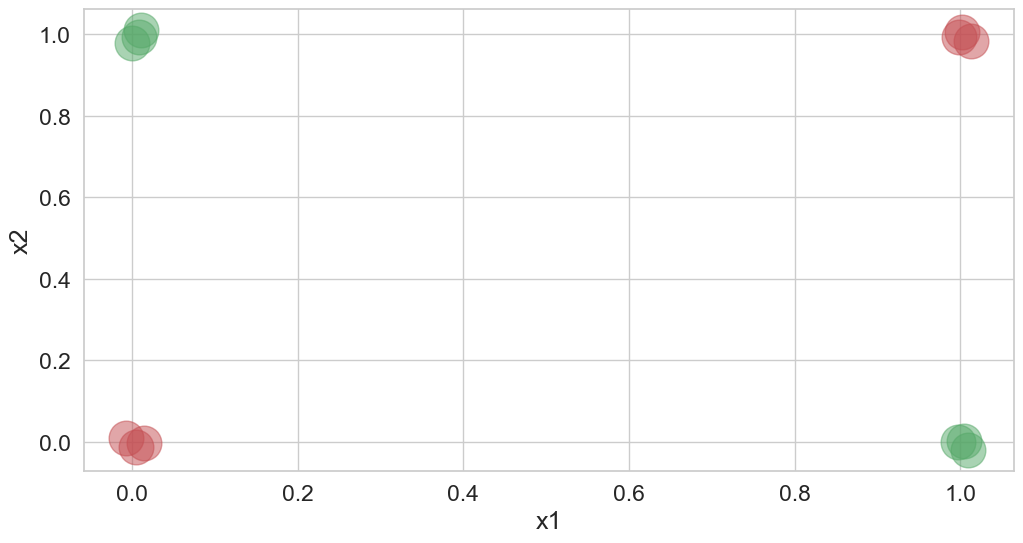

In [82]:
# create some noisy samples from XOR function

def create_xor_data(n):
    np.random.seed(1234)
    ni = int(n / 4)
    d00 = [[0,0] + np.random.randn(2)/1e2 for i in range(ni)]
    d01 = [[0,1] + np.random.randn(2)/1e2 for i in range(ni)]
    d10 = [[1,0] + np.random.randn(2)/1e2 for i in range(ni)]
    d11 = [[1,1] + np.random.randn(2)/1e2 for i in range(ni)]
    y = [0] * ni + [1] * ni * 2 + [0] * ni
    return np.vstack([d00, d01, d10, d11]), np.array(y)

X, y = create_xor_data(12)
print(X)
print(y)

plt.figure()
plot_data(X, y, 'x1', 'x2')
plt.show()

coef= [[ 0.00158582 -0.00386544]]
intercept= [0.0011086]


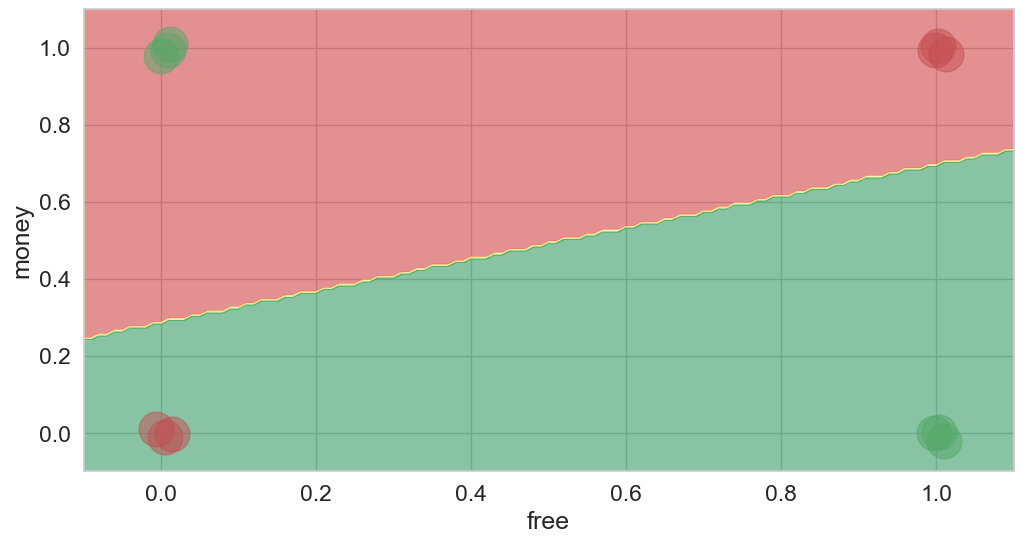

In [83]:
# Fit LogisticRegression and plot the decision surface

lr.fit(X, y)
print('coef=', lr.coef_)
print('intercept=', lr.intercept_)
plt.figure()
plot_data(X, y, 'free', 'money')
plot_decision_surface(lr)
plt.show()


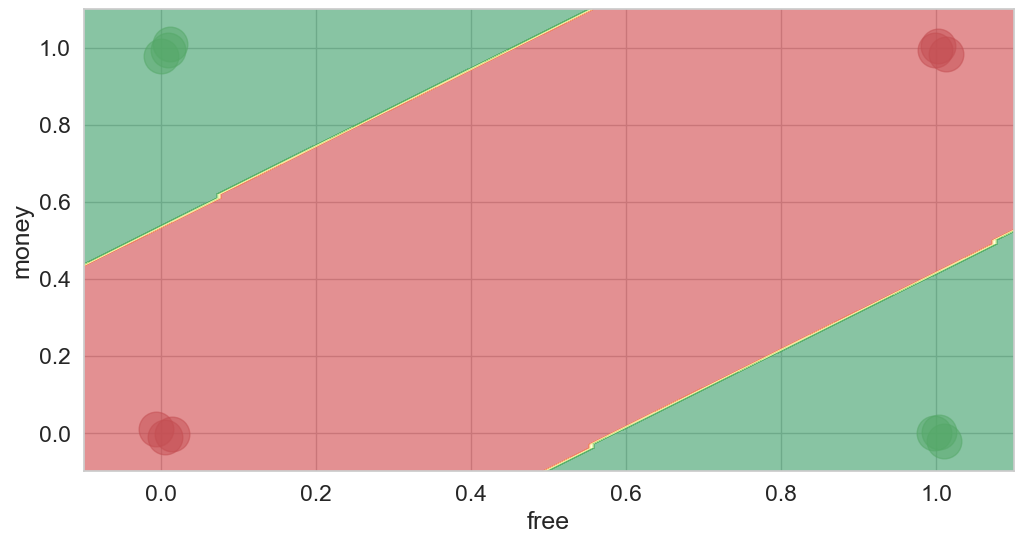

In [84]:
# Fit a neural net and plot the decision surface.
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=[2],
                    activation='logistic',
                    solver='lbfgs',
                    random_state=1234)
mlp.fit(X, y)
plt.figure()
plot_data(X, y, 'free', 'money')
plot_decision_surface(mlp)
plt.show()


<br><br><br>

let's see what the hidden layer is doing...

In [85]:
# input -> hidden layer weights.
pd.DataFrame(mlp.coefs_[0], columns=["$\Theta^1$", "$\Theta^2$"])
# first column are parameters used to compute first hidden unit
# second column are used to compute second hidden unit

,$\Theta^1$,$\Theta^2$
0,-6.873039,-6.989536
1,6.743132,6.876060


In [86]:
# hidden -> output layer weights
pd.DataFrame(mlp.coefs_[1], columns=["$\lambda$"])

,$\lambda$
0,-16.306997
1,15.960720


In [87]:
mlp.intercepts_

[array([ 4.12861442, -3.74179985]), array([8.46671365])]

In [88]:
from math import exp

def f(x, theta):
    return np.dot(x.T, theta)

def logistic(x, theta):
    return 1 / (1 + exp(-f(x, theta)))

h0 = np.array([mlp.coefs_[0][0][0], mlp.coefs_[0][1][0], mlp.intercepts_[0][0]])
h1 = np.array([mlp.coefs_[0][0][1], mlp.coefs_[0][1][1], mlp.intercepts_[0][1]])
o1 = np.array([mlp.coefs_[1][0], mlp.coefs_[1][1], mlp.intercepts_[1][0]], dtype=object)

In [89]:
def projection(x, h0, h1):
    """
    Project input x into values for h0 and h1
    First step of the "forward" pass of a neural net.
    """
    h0x = logistic(x, h0)
    h1x = logistic(x, h1)
    return h0x, h1x

# project (0,0)
# note: add 1 for intercept term
projection(np.array([0,0,1]), h0, h1)

(0.9841500872534491, 0.02316218023761469)

In [90]:
# create a LogisticRegression output for the final layer
outclf = LogisticRegression()
outclf.fit(X,y)  # just creating dummy variables
outclf.intercept_ = o1[2]
outclf.coef_ = np.array([[o1[0], o1[1]]])

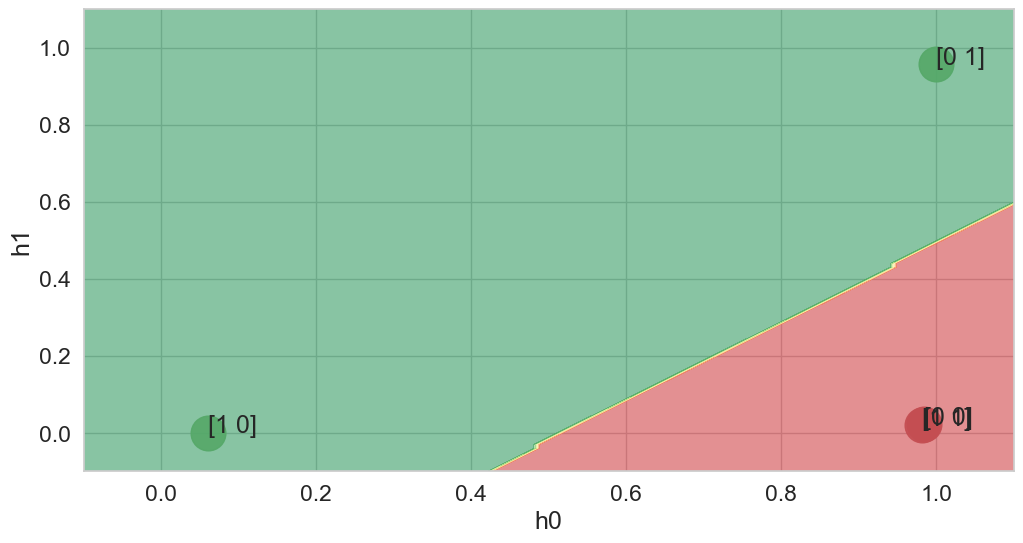

In [91]:
# plot decision surface in projected space.
def xor(p0, p1):
    return p0 != p1

plt.figure()
for xi in np.array([[0,0,1], [0,1,1], [1,0,1], [1,1,1]]):
    p0, p1 = projection(xi, h0, h1)
    plt.plot(p0, p1, marker='.', ms=50, color='g' if xor(xi[0], xi[1]) else 'r', alpha=.9)
    plt.annotate(str(xi[:2]), (p0, p1))
plot_decision_surface(outclf)
plt.xlabel('h0')
plt.ylabel('h1')
plt.show()

## Error Functions

In addition to likelihood, we can consider many other error functions, given true label $y_i$ and predicted output $\hat{y}_i$ for instance $i$:

- Squared Error: 
$$\sum_i (y_i - \hat{y}_i)^2 $$

- Cross-entropy
$$ \sum_i y_i \ln \hat{y}_i + (1-y_i)\ln(1-\hat{y}_i)$$

## Activation functions

Similarly, we have many choices for activation function:

- Sigmoid:
$$ f(t) = \frac{1}{1 + e^{-t}} $$

- Rectified linear function
$$ f(t) = \mathrm{max}(0, t)$$

- tanh
$$f(t) = \frac{e^t - e^{-t}}{e^t + e^{-t}}$$

- Softmax
$$ f(t_i) = \frac{e^{t_i}}{\sum_j e^{t_j}}$$

![figs/activation.png](figs/activation.png)

[source](https://github.com/jacobeisenstein/gt-nlp-class)

This choice can affect learning rate and convergence. Additional reading on [vanishing and exploding gradients](https://medium.com/@karpathy/yes-you-should-understand-backprop-e2f06eab496b)!